In [1]:
from pathlib import Path

import numba as nb
import numpy as np
import scipy.stats as stats

from natsort import natsorted

import matplotlib.pyplot as plt


#plt.style.use("mike")
#import warnings
#warnings.simplefilter("ignore")
#warnings.filterwarnings("ignore")


import astropy.units as u

import cmasher as cmr

green = "#33FF86"
purple = "#CE33FF"

%matplotlib widget
from cosmogrb.universe.survey import Survey

import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from zusammen.stan_models.stan_model import get_model
from zusammen import AnalysisBuilder, DataSet
from zusammen.spectral_plot import display_posterior_model_counts

from threeML import update_logging_level

import arviz as av


update_logging_level("FATAL")


from astromodels import Band_Calderone, PointSource, Model


from threeML import JointLikelihood, DataList, display_spectrum_model_counts

from astromodels import Cutoff_powerlaw

import popsynth as ps

11:31:48 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=502717;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=712081;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py#50\50]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=55888;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=745247;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py#71\71]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=612145;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=252530;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

11:31:48 INFO      Starting 3ML!                                                                     ]8;id=958901;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=920735;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#31\31]8;;\

         WARNING   no display variable set. using backend for graphics without display (agg)         ]8;id=579173;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=562580;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=756263;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=451295;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=4141;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=630093;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=485961;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=321639;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=153073;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=66686;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#79\79]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=803047;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=560077;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#129\129]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=275751;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=667599;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#129\129]8;;\
                  software installed and configured?                                                               

11:31:49 WARNING   No fermitools installed                                              ]8;id=775914;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=422692;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

11:31:49 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=759187;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=831847;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#341\341]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=456265;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=55936;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#341\341]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=725150;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=177780;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#341\341]8;;\
                  performances in 3ML                                                                              

Import the survey and process the GRBs

In [ ]:
survey = Survey.from_file('data/survey.h5')
ab = AnalysisBuilder(survey, use_bb=True, sig_min=10, all_above_limit=True)

In [ ]:
ab.write_yaml("test_proc_sig_10.yml")

In [2]:
ds = DataSet.from_yaml("test_proc_sig_10_red.yml")

In [ ]:
ds.to_hdf5_file("sgrb.h5")

In [ ]:
ds = DataSet.from_hdf5_file('sgrb.h5')

In [6]:
data = ds.to_stan_dict()
data

OrderedDict([('N_intervals', 50),
             ('N_grbs', 5),
             ('max_n_echan', 140),
             ('max_n_chan', 128),
             ('object_idx',
              array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
                     3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
                     5, 5, 5, 5, 5, 5])),
             ('grb_id',
              array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
                     3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
                     5, 5, 5, 5, 5, 5])),
             ('N_dets',
              [4,
               4,
               4,
               4,
               4,
               4,
               4,
               4,
               4,
               4,
               4,
               4,
               4,
               4,
               4,
               4,
               4,
               4,
               4,
               4,
 

In [ ]:
maxl = []
for i,j in enumerate(ds.to_stan_dict()["observed_counts"]):
    maxl.append(j.max())
    print(i, j.max())

print(max(maxl))

In [ ]:
%matplotlib widget
i,j = 0,0
plt.plot(ds.to_stan_dict()["response"][i,j].T @ ds.to_stan_dict()['observed_counts'][i,j])

Make Stan model

In [8]:
m = get_model("cpl_simple_chunked_gc")

In [ ]:
m.clean_model()

In [9]:
m.build_model(opt_exp=True)

11:05:42 - cmdstanpy - INFO - compiling stan file /Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan to exe file /Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc
11:05:58 - cmdstanpy - INFO - compiled model executable: /Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc
11:05:58 - cmdstanpy - WARNING - Stan compiler has produced 26 warnings:
11:05:58 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --Oexperimental --include-paths=/Users/chrobin/Documents/zusammen/zusammen/stan_models --o=/Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.hpp /Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan
Warning in '/Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl.stan', line 35, column 41, included from
'/Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 2, column 0: Declaration
    

In [16]:
data = ds.to_stan_dict()

n_threads = 2
n_chains = 2

fit = m.model.sample(
    data=data,
    parallel_chains=n_chains,
    chains=n_chains,
    inits= {
        'alpha': -1 * np.ones(data['N_intervals']),
        'log_ec': 2 * np.ones(data['N_intervals']),

        # 'log_energy_flux': -7 * np.ones(data['N_intervals']),
        # 'log_K': -1 * np.ones(data['N_intervals']),

        # 'log_energy_flux_mu_raw': 0,
        # 'log_energy_flux_sigma': 1,
        # 'log_energy_flux_raw': np.zeros(data['N_intervals']),

        'gamma_sig_meta': 1,
        'log_Nrest_sig_meta': 1,
        'gamma_mu_meta': 1,
        'log_Nrest_mu_meta': 52,
        'gamma': np.ones(data['N_grbs']),
        'log_Nrest': 52 * np.ones(data['N_grbs'])
    },  # type: ignore
    threads_per_chain=n_threads,
    seed=1234,
    iter_warmup=1000,
    iter_sampling=500,
    max_treedepth=12,
    adapt_delta=0.9,
    # step_size=0.1,
    show_progress=True,
    # show_console=True,
    refresh=10
)

09:34:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:47:28 - cmdstanpy - INFO - CmdStan done processing.
13:47:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: integrate: error estimate of integral 1.0581e-14 exceeds the given relative tolerance times norm of integral (in '/Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 151, column 4 to column 105)
	Exception: integrate: error estimate of integral 6.48216e-06 exceeds the given relative tolerance times norm of integral (in '/Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 151, column 4 to column 105)
	Exception: integrate: error estimate of integral 5.58595e-06 exceeds the given relative tolerance times norm of integral (in '/Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 151, column 4 to column 105)
	Exception: integrate: error estimate of integral 2.6213e-06 exceeds the given relative tolerance times norm of integral (in '/Users/chrobin/Docum

In [ ]:
fit.diagnose()

Import Stan results into arviz

In [23]:
res = av.from_cmdstanpy(fit)

In [24]:
res.to_netcdf("inference_data/testing_low_z_sig_10.nc")

'inference_data/testing_low_z_sig_10.nc'

In [3]:
res = av.from_netcdf("inference_data/testing_low_z_sig_10.nc")

In [ ]:
res.sample_stats.tree_depth.max()

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'log_ec'}>,
        <AxesSubplot:title={'center':'log_ec'}>],
       [<AxesSubplot:title={'center':'log_energy_flux_mu_raw'}>,
        <AxesSubplot:title={'center':'log_energy_flux_mu_raw'}>],
       [<AxesSubplot:title={'center':'log_energy_flux_sigma'}>,
        <AxesSubplot:title={'center':'log_energy_flux_sigma'}>],
       [<AxesSubplot:title={'center':'log_energy_flux_raw'}>,
        <AxesSubplot:title={'center':'log_energy_flux_raw'}>],
       [<AxesSubplot:title={'center':'ec'}>,
        <AxesSubplot:title={'center':'ec'}>],
       [<AxesSubplot:title={'center':'log_energy_flux'}>,
        <AxesSubplot:title={'center':'log_energy_flux'}>],
       [<AxesSubplot:title={'center':'log_energy_flux_mu'}>,
        <AxesSubplot:title={'center':'log_energy_flux_mu'}>],
       [<AxesSubplot:title={'center':'energy_flux'}>,
        <AxesSubplot:title={'cente

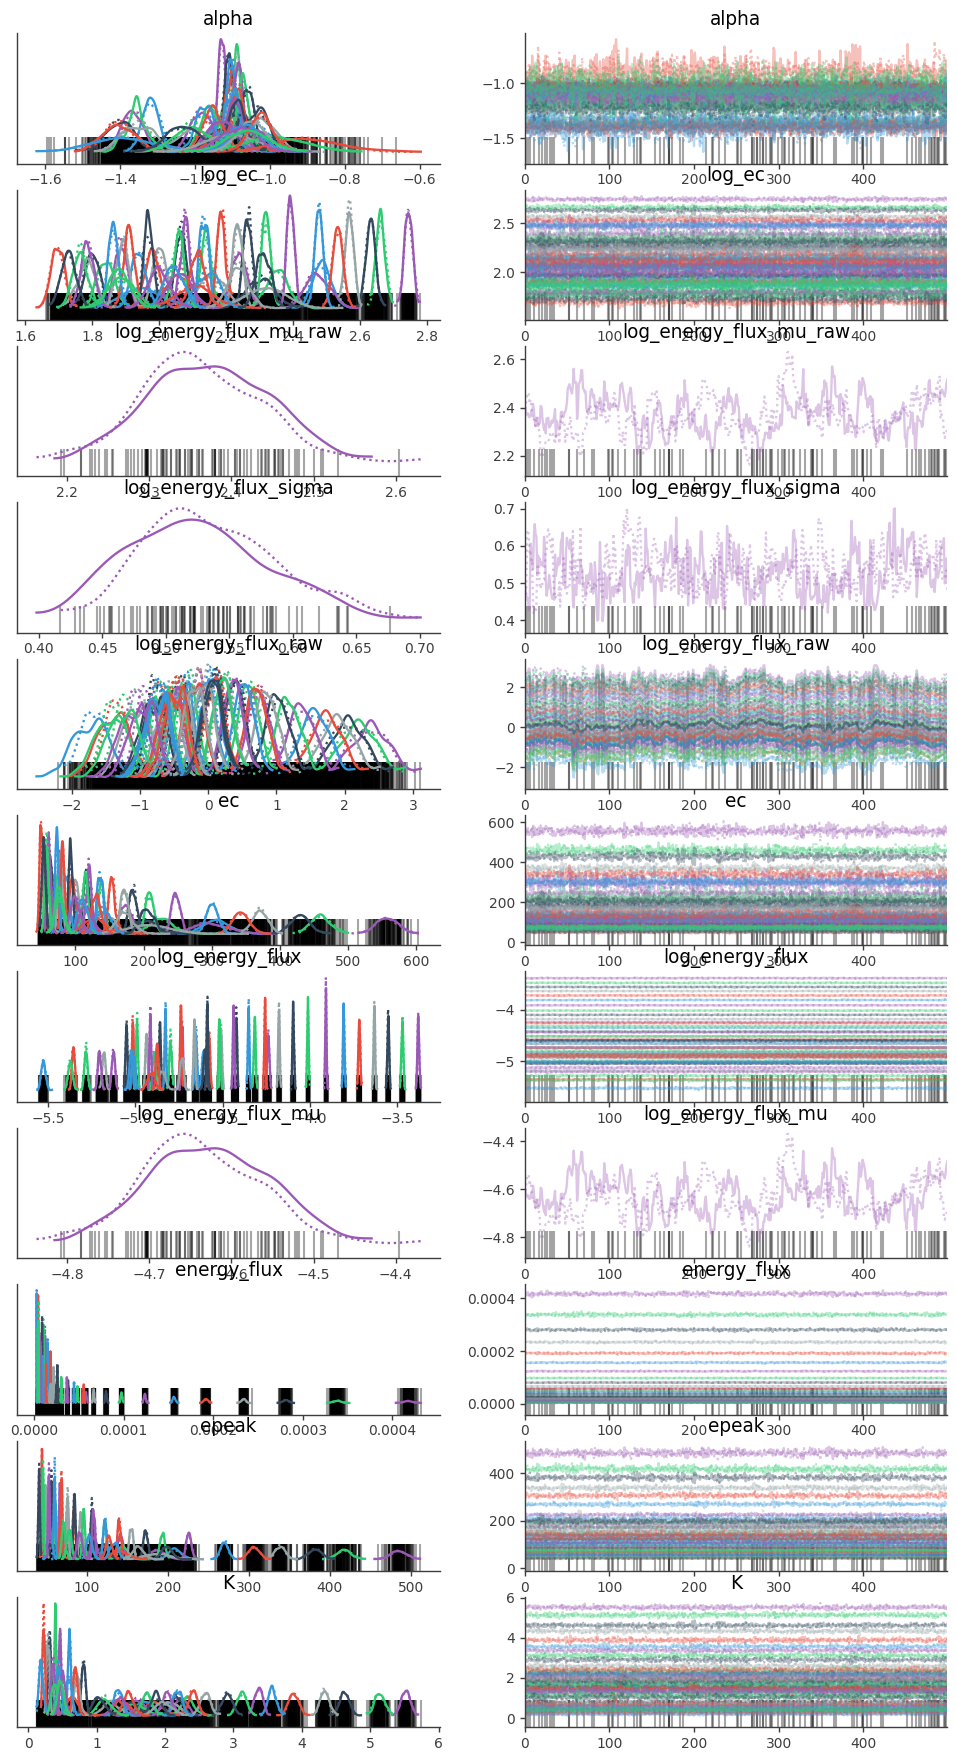

In [11]:
%matplotlib widget
av.plot_trace(res)

In [5]:
%matplotlib widget
for i in range(data['N_intervals']):
    av.plot_trace(res, var_names=["ec"], coords={"ec_dim_0": i})

NameError: name 'data' is not defined

In [ ]:
%matplotlib widget
av.plot_pair(res, divergences=True)

In [ ]:
div = res.sample_stats.diverging.stack(sample=("chain", "draw")).values
div.sum()

Load parameters  

In [ ]:
id = 0


alpha = res.posterior.alpha.stack(sample=("chain", "draw")).values[id]

log_ec = res.posterior.log_ec.stack(sample=("chain", "draw")).values[id]

K  = res.posterior.K.stack(sample=("chain", "draw")).values[id]

# log_epeak = res.posterior.log_epeak.stack(sample=("chain", "draw")).values[id]

energy_flux = res.posterior.energy_flux.stack(sample=("chain", "draw")).values[id]

# gamma = res.posterior.gamma.stack(sample=("chain", "draw")).values[id]

# log_Nrest = res.posterior.log_Nrest.stack(sample=("chain", "draw")).values[id]


div = res.sample_stats.diverging.stack(sample=("chain", "draw")).values

samples = np.vstack((K, alpha, 10.**log_ec))


dl = ds.get_data_list_of_interval(id)

In [ ]:
log_ec.mean()

In [ ]:
div.sum()

In [ ]:
bc = Cutoff_powerlaw(piv=100)

bc.index.bounds = (None, None)
bc.K.bounds = (None, None)
bc.xc.bounds = (None, None)

model = Model(PointSource("ps",0,0, spectral_shape=bc))

In [ ]:
%matplotlib widget
#fig, ax = plt.subplots()

plt.scatter(log_ec, alpha, alpha=0.1)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(K, alpha, alpha=0.1)

In [ ]:
display_posterior_model_counts(
    dl[1], model, samples.T[::20], min_rate=1e-99, shade=False
)

In [ ]:
cpl = Cutoff_powerlaw(piv=100,K=1e-1,xc=200)


dl = ds.get_data_list_of_interval(2)

model = Model(PointSource("ps",0,0, spectral_shape=cpl))

ba = JointLikelihood(model,DataList(*dl))

In [ ]:
ba.fit()

In [ ]:
display_spectrum_model_counts(ba)

In [ ]:
dl[0].view_count_spectrum()

In [ ]:
cpl